## Chargement des publications

Les publications de l'étape `1-Aggregation` peuvent être récupérées avec [ce lien dropbox (26 Mo)](https://www.dropbox.com/s/y1hf5ux8r5btmnn/publications.pk.bz2?dl=1
) 

In [2]:
import bibdb
import pickle, bz2

data = pickle.load(bz2.open('publications.pk.bz2', 'rb'))
titles = data['titles']
abstracts = data['abstracts']
authors = data['authors']
Mauthor_pubs = data['Mauthor_pubs']
profs = data['profs']
del data

Ndocs = len(abstracts)
Nauthors = len(authors)

assert len(titles) == Ndocs
assert Mauthor_pubs.shape == (Nauthors, Ndocs)

## Tokenization et lematization

La fonction `text_cleaning` implémente une tokenization et lematization du corpus a l'aide de la bibliothèque `nltk`. Une liste de stop-words anglais est utilisée, les nombres sont transformé en `[number]` et la ponctuation est retirée.

La lematization est réalisée avec wordnet et un POS tagger (Perceptron Tagger de nltk). Les deux premières lettres du tag sont rajoutées au lemme : "word/NN".

In [ ]:
from text_cleaning import text_cleaning

lem_abstracts = []
lem_titles = []
for i in range(Ndocs):
    if i & 1023 == 0:
        print('%.2f%%' % (100*i/Ndocs))
    
    lem_abstracts.append(text_cleaning(abstracts[i]))
    
    title = titles[i]
    if title:
        lem_titles.append(text_cleaning(title))
    else:
        lem_titles.append([]) # keeps lists aligned

0.00%
1.68%
3.35%
5.03%
6.71%
8.39%
10.06%
11.74%
13.42%
15.10%
16.77%
18.45%
20.13%
21.80%
23.48%
25.16%
26.84%
28.51%
30.19%
31.87%
33.55%
35.22%
36.90%
38.58%
40.25%
41.93%
43.61%
45.29%
46.96%
48.64%


Cette opération prend du temps (20min) et donc les résultats sont sauvegardés :

In [ ]:
pickle.dump(dict(lem_abstracts=lem_abstracts,
                 lem_titles=lem_titles),
            bz2.open('lems.pk.bz2', 'wb'))

Le résultat de la lemmatisation est accesible [sur ce lien dropbox (27 Mo)](https://www.dropbox.com/s/pyu7n2tsztnu0js/lems.pk.bz2?dl=1)

In [8]:
import pickle, bz2
data = pickle.load(bz2.open('lems.pk.bz2', 'rb'))
lem_abstracts = data['lem_abstracts']
lem_titles = data['lem_titles']
del data, titles, abstracts

In [9]:
lem_abstract_withtitles = [lem_title + lem_abstract 
                           for lem_title, lem_abstract in zip(lem_titles, lem_abstracts)]
del lem_abstracts, lem_titles

## Fréquences document des mots et filtrage

Les lemmes taggés sont ensuite indexés avec `gensim.corpora.Dictionary`. Cet objet calcule également la fréquence document des mots.

In [10]:
from itertools import chain
import gensim

dictionary = gensim.corpora.Dictionary(lem_abstract_withtitles)

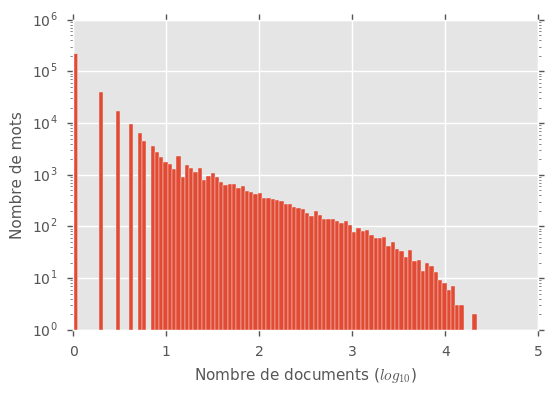

In [11]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

plt.hist([np.log10(count) for count in dictionary.dfs.values()],
         100, log=True)
plt.xlabel('Nombre de documents ($log_{10}$)')
plt.ylabel('Nombre de mots');

Les mot utilisés moins dans moins de 5 documents, ou dans plus de 1/4 des document sont retirés :

In [12]:
dictionary.filter_extremes(no_below=5, no_above=0.25, keep_n=None)

## Modèle `bag of words` par publication
Un modèle `bag of words` est construit en utilisant les indices numériques de `dictionary` (cela filtre aussi les mots).

In [13]:
# Make a scipy sparse matrix representation of the corpus, more memory efficient :
bows_csc = gensim.matutils.corpus2csc((dictionary.doc2bow(lems) 
                                       for lems in lem_abstract_withtitles),
                                      num_terms=len(dictionary.token2id), 
                                      num_docs=len(lem_abstract_withtitles))

gen_bows = lambda: gensim.matutils.Sparse2Corpus(bows_csc)
del lem_abstract_withtitles

In [33]:
tfidfmodel = gensim.models.tfidfmodel.TfidfModel(gen_bows(), dictionary=dictionary)
lsimodel = gensim.models.lsimodel.LsiModel(tfidfmodel[gen_bows()], id2word=dictionary)
# lsimodel.save('lsimodel_bypub')

plt.plot(lsimodel.projection.s);

In [8]:
hdpmodel = gensim.models.hdpmodel.HdpModel(tfidfmodel[gen_bows()], dictionary)
hdpmodel.save('hdpmodel_bypub.pk')

## Moyenne des modèles BoW par auteurs

## Modèles BoW par auteurs, abstracts concaténés

L'attribution des termes des abstracts à un auteur se fait de la façon suivante : 

$$ \#_\textrm{occs}(\textrm{terme}, \textrm{auteur}) = \sum_\textrm{publication} \frac{
    \delta_E( \textrm{auteur}, \textrm{publication} )
 }{ 
    \#_\textrm{auteurs}(\textrm{publication})
 }
 \#_\textrm{occs}(\textrm{terme}, \textrm{publication})
$$

Où $\delta_E( \textrm{auteur}, \textrm{publication} )$ indique si l'auteur participe dans la publication (1 ou 0 sinon). Ce sont les entrées de la matrices auteur / publication `Mauthor_pubs` définie après le chargement des données. Notament : 

$$ \#_\textrm{auteurs}(\textrm{publication}) = 
\sum_{auteur} \delta_E( \textrm{auteur}, \textrm{publication} ) $$

Ainsi, les termes des publications avec peu d'auteurs ont plus de poids.

Avec l'aide de la matrice d'une matrice diagonale

$$
D = \textrm{diag} \left(
\frac{1}{\#_\textrm{auteurs}(\textrm{publication})}
\right)
$$
    
le modèle BoW par auteur peut se calculer par un produit matriciel : 

In [17]:
# Matrice diagonale diag(1/#auteurs(abstract)):
D = sparse.dia_matrix((1/Mauthor_pubs.sum(axis=0).ravel(), [0]), (Ndocs, Ndocs))

# Enfin:
bows_author_csc = bows_csc * (Mauthor_pubs * D).T

gen_bows_authors = lambda: gensim.matutils.Sparse2Corpus(bows_author_csc)

del D
bows_author_csc

<47894x64418 sparse matrix of type '<class 'numpy.float64'>'
	with 30480351 stored elements in Compressed Sparse Column format>

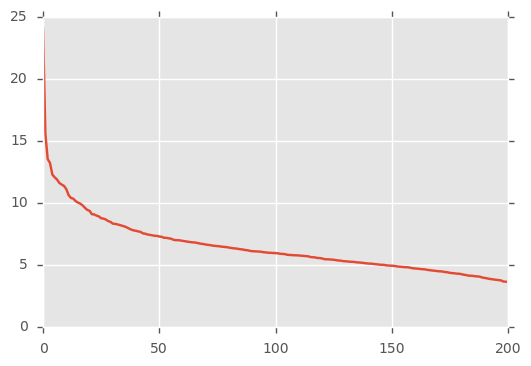

In [18]:
tfidfmodel = gensim.models.tfidfmodel.TfidfModel(gen_bows_authors(), dictionary=dictionary)
lsimodel = gensim.models.lsimodel.LsiModel(tfidfmodel[gen_bows_authors()], id2word=dictionary)
lsimodel.save('lsimodel_byauthor')

plt.plot(lsimodel.projection.s);
plt.xlabel('Dimension lattente')
plt.ylabel('Valeurs singulières')

In [ ]:
hdpmodel = gensim.models.hdpmodel.HdpModel(gen_bows_authors(), dictionary)
hdpmodel.save('hdpmodel_byauthor.pk')